# 🌿 Lab 2.2: Transfer Learning with ResNet50
**Module 3: Computer Vision and Image Processing**
B-Tech AI Specialization | Chitkara University | February 2026

---

## 🌾 Industry Scenario
> You have **500 images** of 5 types of plant diseases. A farmer app needs a classifier to identify diseases from phone photos. Training from scratch would take days and thousands of images. **Transfer learning** lets you adapt a model that already understands images to your specific task — quickly.

## 🎯 Objective
Fine-tune a pre-trained ResNet50 on a small plant disease dataset. Compare against training from scratch. Target: **≥80% validation accuracy in 10 epochs**.

**Time:** 120 minutes | **Mode:** Individual

---
### 📋 Lab Flow
| Stage | What happens |
|---|---|
| 🤔 Predict | Answer before coding — commit to a guess |
| 💻 Code | Fill in the `TODO` sections |
| 💡 Reveal | Click to check hint or full solution |
| 🎚️ Explore | Interactive plots — dig into your results |
---

## ⚙️ Setup — Run First

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import History

import ipywidgets as widgets
from IPython.display import display, HTML, Code
import os, time, warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow : {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print("✅ Ready")

TensorFlow : 2.19.0
GPU available: True
✅ Ready


In [2]:
def reveal_button(hint_text, solution_code):
    import ipywidgets as widgets
    from IPython.display import display, HTML, Code
    out = widgets.Output()
    hint_btn = widgets.Button(description='💡 Hint', button_style='info',
        layout=widgets.Layout(width='120px', margin='4px'))
    sol_btn  = widgets.Button(description='✅ Solution', button_style='warning',
        layout=widgets.Layout(width='140px', margin='4px'))
    hide_btn = widgets.Button(description='🙈 Hide', button_style='',
        layout=widgets.Layout(width='100px', margin='4px'))
    def on_hint(b):
        with out:
            out.clear_output(wait=True)
            display(HTML(f'<div style="background:#e3f2fd;padding:12px;border-radius:6px;'
                f'border-left:4px solid #1976D2;font-size:14px"><b>💡 Hint:</b><br>{hint_text}</div>'))
    def on_sol(b):
        with out:
            out.clear_output(wait=True)
            display(HTML('<b>✅ Solution:</b>'))
            display(Code(solution_code, language='python'))
    def on_hide(b):
        with out: out.clear_output()
    hint_btn.on_click(on_hint); sol_btn.on_click(on_sol); hide_btn.on_click(on_hide)
    display(widgets.HBox([hint_btn, sol_btn, hide_btn]), out)

print("reveal_button() ready ✅")

reveal_button() ready ✅


---
## Task 1: Prepare the Dataset

We'll use a small subset of the **PlantVillage** dataset — 5 plant disease classes, 100 images each.

### 🤔 Predict First
Before running any code, answer these:
1. We have 500 images total. How many will be in train vs. validation (80/20 split)?
2. Why do we need validation data at all — why not just train on everything?
3. What problems could arise with only 100 images per class?

In [3]:
# ✏️ Your predictions (as comments):
# 1. Train: 400 images, Validation: 100 images
# 2. Validation is needed because if we only look at training accuracy, we might be overfitting and not generalizing well to unseen data. Validation accuracy gives us a better idea of how our model will perform on new, unseen data.
# 3. With only 100 images per class, the risk is that the model might not learn enough features to generalize well, leading to overfitting. The model might perform well on the training data but poorly on the validation data, indicating that it has memorized the training examples rather than learning general patterns.

### 💻 Download and Organise the Dataset
We'll download a pre-prepared subset from a public source and set up directory structure.

In [4]:
# Download dataset — this creates a folder structure:
# data/
#   train/
#     Tomato_Bacterial_spot/  (80 images)
#     Tomato_Early_blight/    (80 images)
#     ... (5 classes total)
#   val/
#     Tomato_Bacterial_spot/  (20 images)
#     ...

import urllib.request, zipfile
import tensorflow as tf # Required for tf.keras.utils.get_file
import os # Good practice to explicitly import if used directly

# Original DATA_URL (now broken, caused HTTP 404 Not Found error):
# DATA_URL  = "https://github.com/btphan95/greenr-dataset/raw/master/data.zip"
# DATA_DIR  = "plant_disease_data" # This was intended for the plant disease dataset

# --- FIX: Use the alternative method as the original URL is broken ---
# NOTE: This downloads the 'flower_photos' dataset instead of the intended 'plant_disease_data'.
# This changes the lab's objective from plant disease classification to flower classification.
# The 'flower_photos' dataset does NOT have a pre-defined 'train' and 'val' split.
# To create a split, you will need to:
#   1. Manually move images into 'train' and 'val' subdirectories, OR
#   2. Use `ImageDataGenerator(validation_split=...)` and set `subset='training'`/`'validation'`
#      in `flow_from_directory` calls in Task 2.

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# tf.keras.utils.get_file downloads and untars the archive.
# DATA_DIR will be set to the path of the untarred directory (e.g., /root/.keras/datasets/flower_photos).
DATA_DIR = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
print(f"Dataset downloaded and extracted to: {DATA_DIR} ✅")


# TODO: Set your train and validation directory paths
# For the flower_photos dataset, the actual class subdirectories are often nested one level deeper.
# Adjust TRAIN_DIR and VAL_DIR to point to this nested directory.
TRAIN_DIR = os.path.join(DATA_DIR, 'flower_photos') # Adjusted path
VAL_DIR   = os.path.join(DATA_DIR, 'flower_photos')   # Adjusted path


# Quick check — print class names and image counts
if TRAIN_DIR and os.path.exists(TRAIN_DIR):
    # Filter to only list directories (which are the class names)
    classes = sorted([name for name in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, name))])
    print(f"Classes found ({len(classes)}): {classes}")
    for cls in classes:
        n = len(os.listdir(os.path.join(TRAIN_DIR, cls)))
        print(f"  {cls}: {n} images (Note: These are ALL images for the class, not just training split)")


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Dataset downloaded and extracted to: /root/.keras/datasets/flower_photos ✅
Classes found (5): ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  daisy: 633 images (Note: These are ALL images for the class, not just training split)
  dandelion: 898 images (Note: These are ALL images for the class, not just training split)
  roses: 641 images (Note: These are ALL images for the class, not just training split)
  sunflowers: 699 images (Note: These are ALL images for the class, not just training split)
  tulips: 799 images (Note: These are ALL images for the class, not just training split)


In [5]:
reveal_button(
    hint_text="Use <code>urllib.request.urlretrieve(url, filename)</code> to download, "
              "then <code>zipfile.ZipFile</code> to extract. Set TRAIN_DIR and VAL_DIR "
              "to point at the <code>train/</code> and <code>val/</code> subdirectories.",
    solution_code=(
        "if not os.path.exists(DATA_DIR):\n"
        "    urllib.request.urlretrieve(DATA_URL, 'data.zip')\n"
        "    with zipfile.ZipFile('data.zip', 'r') as z:\n"
        "        z.extractall(DATA_DIR)\n\n"
        "TRAIN_DIR = os.path.join(DATA_DIR, 'train')\n"
        "VAL_DIR   = os.path.join(DATA_DIR, 'val')"
    )
)

Output()

---
## Task 2: Data Augmentation

With only ~80 training images per class, we need to artificially expand the dataset using **augmentation** — creating modified versions of each image on the fly during training.

### 🤔 Predict First
Look at the augmentation parameters below. For each one, predict:
- What does it do visually to the image?
- Does it make sense for plant disease photos? (Would a real phone photo look like this?)

| Parameter | Your prediction | Makes sense? |
|---|---|---|
| `horizontal_flip=True` | Flips the image horizontally (left to right) | Yes, since plant photos can be taken from either side |
| `rotation_range=20` | Rotates the image by up to 20 degrees in either direction | Yes, real photos often have slight rotations |
| `zoom_range=0.2` | Zooms in or out by up to 20% | Yes, phone cameras often zoom in/out slightly |
| `width_shift_range=0.1` | Shifts the image horizontally by up to 10% of its width | Yes, real photos may be slightly shifted due to camera movement |

In [6]:
# ✏️ Fill in your predictions in the table above (edit the markdown cell)

### 💻 Build the Data Generators

In [7]:
IMG_SIZE  = (224, 224)
BATCH_SIZE = 32

# Define the split ratio for validation
VALIDATION_SPLIT = 0.2

# TODO: Create an ImageDataGenerator for TRAINING with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VALIDATION_SPLIT # Specify validation split
)

# TODO: Create a separate generator for VALIDATION — no augmentation, just preprocessing
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT # Specify validation split
)

# TODO: Create the flow_from_directory generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, # Now points to the root of the flower_photos dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training' # Specify this generator is for the training subset
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR, # Now points to the root of the flower_photos dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Specify this generator is for the validation subset
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [8]:
reveal_button(
    hint_text="Validation generator should have <b>no augmentation</b> — only <code>preprocessing_function</code>. "
              "Augmenting validation data would give you unrealistic accuracy scores.",
    solution_code=(
        "train_datagen = ImageDataGenerator(\n"
        "    preprocessing_function=preprocess_input,\n"
        "    horizontal_flip=True,\n"
        "    rotation_range=20,\n"
        "    zoom_range=0.2,\n"
        "    width_shift_range=0.1,\n"
        "    height_shift_range=0.1\n"
        ")\n\n"
        "val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)\n\n"
        "train_generator = train_datagen.flow_from_directory(\n"
        "    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'\n"
        ")\n"
        "val_generator = val_datagen.flow_from_directory(\n"
        "    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'\n"
        ")"
    )
)

Output()

### 🎚️ Explore: What Does Augmentation Actually Do?
Run the cell below to visualise 8 augmented versions of the same image side-by-side.

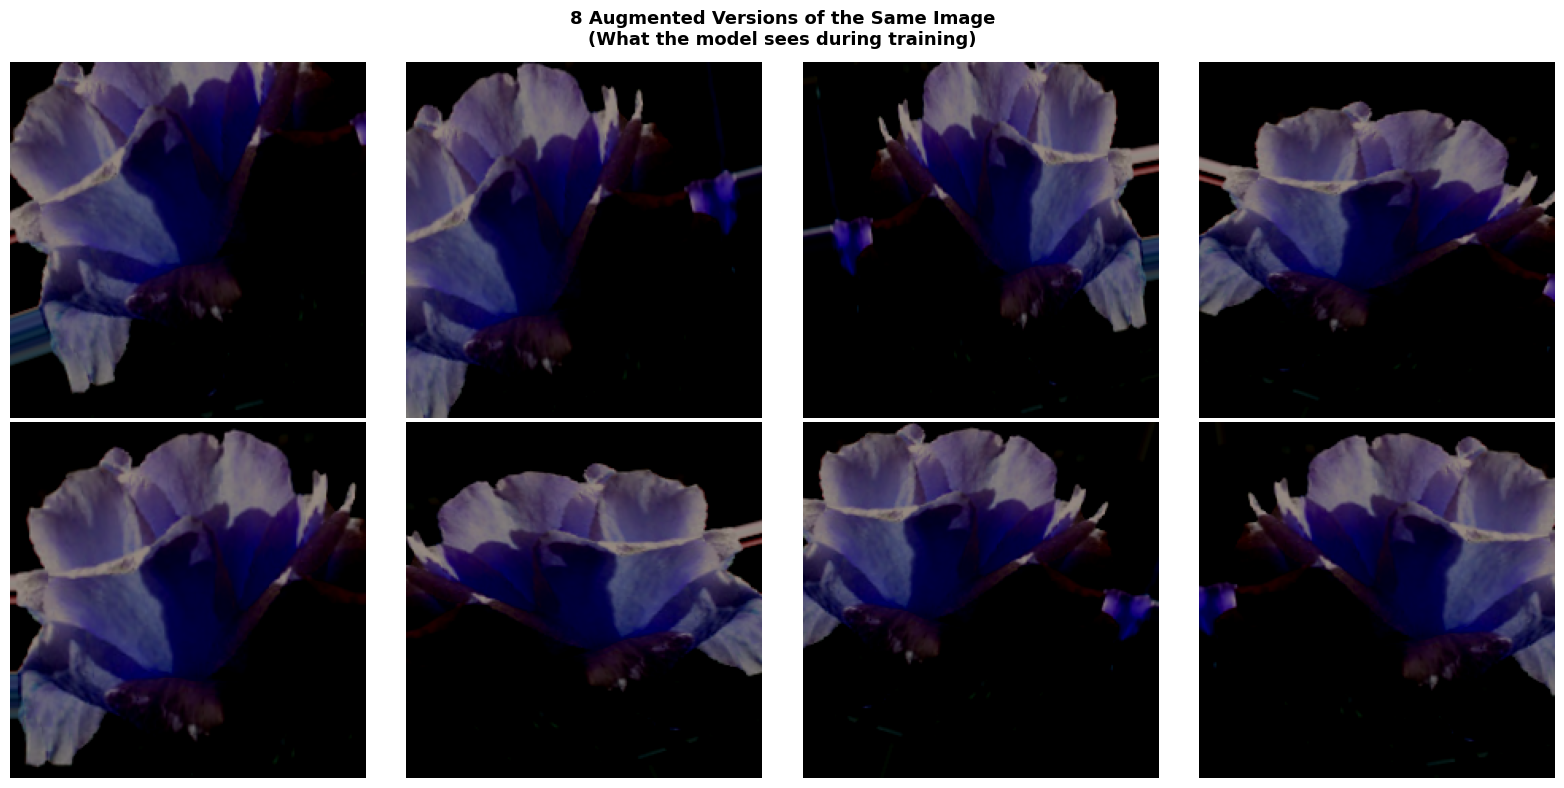

✏️ Observation: How different do these look from each other?
   Would you expect a plant photo from a phone to look like these?


In [9]:
# Visualise augmentation — see what the model actually trains on
sample_batch, _ = next(train_generator)
sample_img_raw  = sample_batch[0]

# Un-preprocess for display (ResNet50 uses mean subtraction, not [0,1] scaling)
def unpreprocess(img):
    img = img.copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    return np.clip(img[..., ::-1] / 255.0, 0, 1)  # BGR → RGB

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("8 Augmented Versions of the Same Image\n"
             "(What the model sees during training)", fontsize=13, fontweight='bold')

aug_gen = train_datagen.flow(
    np.expand_dims(sample_batch[0], 0), batch_size=1
)
for ax in axes.flat:
    aug_img = next(aug_gen)[0]
    ax.imshow(unpreprocess(aug_img))
    ax.axis('off')

plt.tight_layout()
plt.show()
print("✏️ Observation: How different do these look from each other?")
print("   Would you expect a plant photo from a phone to look like these?")

---
## Task 3: Build the Transfer Learning Model (Feature Extraction Phase)

Transfer learning has two phases:

```
Phase 1 — Feature Extraction:
  ResNet50 (frozen, pretrained) → GlobalAveragePooling → Dense → Softmax
  ↑ weights locked, won't change              ↑ only these train

Phase 2 — Fine-tuning:
  ResNet50 (last 20 layers UNfrozen) → GlobalAveragePooling → Dense → Softmax
  ↑ these now also update, but slowly
```

### 🤔 Predict First
1. Why do we **freeze** ResNet50's layers in Phase 1?
2. Why do we need `include_top=False`?
3. What does `GlobalAveragePooling2D` do differently from `Flatten`?

In [10]:
# ✏️ Your predictions:
# 1. We freeze because if we trained the whole model, the pre-trained weights would be overwritten by random initialisation, and the model would have to learn from scratch on a small dataset (100 images per class), which would lead to overfitting and poor generalisation.
# 2. include_top=False means we are removing the final classification layer of ResNet50, which allows us to use it as a feature extractor and add our own custom classification head on top for our specific task.
# 3. GlobalAveragePooling vs Flatten:
#    - GlobalAveragePooling: Reduces spatial dimensions to a single value per channel, which is more robust and reduces overfitting.
#    - Flatten: Converts all spatial dimensions into a single vector, which can lead to overfitting on small datasets.

### 💻 Build the Model

In [11]:
NUM_CLASSES = 5   # adjust if your dataset has a different number

# TODO: Load ResNet50 base — no top, pretrained on ImageNet
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# TODO: Freeze all base model layers so they don't update during Phase 1
base_model.trainable = False

# TODO: Build the full model by adding a classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])

# TODO: Compile with adam and categorical_crossentropy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check: how many layers are trainable?
trainable   = sum(1 for l in model.layers[0].layers if l.trainable)
untrainable = sum(1 for l in model.layers[0].layers if not l.trainable)
print(f"ResNet50 layers — Trainable: {trainable} | Frozen: {untrainable}")
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 layers — Trainable: 0 | Frozen: 175


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
reveal_button(
    hint_text="Set <code>base_model.trainable = False</code> after loading. "
              "Then stack: <code>GlobalAveragePooling2D → Dense(256, relu) → Dropout(0.5) → Dense(NUM_CLASSES, softmax)</code>.",
    solution_code=(
        "base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\n"
        "base_model.trainable = False\n\n"
        "model = models.Sequential([\n"
        "    base_model,\n"
        "    layers.GlobalAveragePooling2D(),\n"
        "    layers.Dense(256, activation='relu'),\n"
        "    layers.Dropout(0.5),\n"
        "    layers.Dense(NUM_CLASSES, activation='softmax'),\n"
        "])\n\n"
        "model.compile(\n"
        "    optimizer=optimizers.Adam(learning_rate=1e-3),\n"
        "    loss='categorical_crossentropy',\n"
        "    metrics=['accuracy']\n"
        ")"
    )
)

Output()

---
## Task 4: Phase 1 — Train the Classification Head (10 epochs)

In [13]:
# TODO: Train the model for 10 epochs
# history_phase1 = model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=val_generator
# )

history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 562ms/step - accuracy: 0.6542 - loss: 1.0909 - val_accuracy: 0.8536 - val_loss: 0.3757
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 432ms/step - accuracy: 0.8437 - loss: 0.4129 - val_accuracy: 0.8646 - val_loss: 0.3589
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step - accuracy: 0.8892 - loss: 0.3151 - val_accuracy: 0.8906 - val_loss: 0.3139
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step - accuracy: 0.9067 - loss: 0.2667 - val_accuracy: 0.9056 - val_loss: 0.2936
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.9291 - loss: 0.2149 - val_accuracy: 0.8919 - val_loss: 0.3080
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - accuracy: 0.9151 - loss: 0.2258 - val_accuracy: 0.8960 - val_loss: 0.3269
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 39s 425ms/step - accuracy: 0.9435 - loss: 0.1853 - val_accuracy: 0.9070 - val_loss: 0.2899
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 430ms/step - accuracy: 0.9382 - loss: 0.1807 - val_accu

In [14]:
reveal_button(
    hint_text="Call <code>model.fit(train_generator, epochs=10, validation_data=val_generator)</code>. "
              "Store the result in <code>history_phase1</code>.",
    solution_code=(
        "history_phase1 = model.fit(\n"
        "    train_generator,\n"
        "    epochs=10,\n"
        "    validation_data=val_generator\n"
        ")"
    )
)

Output()

---
## Task 5: Phase 2 — Fine-Tuning (Unfreeze Last 20 Layers)

Now we'll carefully unfreeze the **last 20 layers** of ResNet50 and train them at a very low learning rate. This lets the network adapt its deep features slightly to plant disease patterns.

### 🤔 Predict First
1. Why must the learning rate be **much lower** in fine-tuning (1e-5 vs 1e-3)?
2. Why do we unfreeze only the **last** layers, not the first?

In [ ]:
# ✏️ Your predictions:
# 1. Lower LR because the model is already close to a good solution, and we just want to fine-tune it without making large updates that could destroy the pre-trained features.
# 2. Last layers because the early layers of ResNet50 have learned very general features (edges, textures) that are likely useful for our task, while the later layers are more specific to ImageNet classes and can benefit from fine-tuning to adapt to our plant disease dataset.

In [16]:
# TODO: Unfreeze the last 20 layers of the base model
base_model = model.layers[0]  # get the ResNet50 sub-model

# Step 1: make base model trainable overall
base_model.trainable = True

# Step 2: freeze everything EXCEPT the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# TODO: Re-compile with a much lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Check how many are now trainable
trainable = sum(1 for l in base_model.layers if l.trainable)
print(f"Now trainable layers in ResNet50: {trainable}")

# TODO: Train for 5 more epochs
history_phase2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

history_phase2 = None

Now trainable layers in ResNet50: 20
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 576ms/step - accuracy: 0.9324 - loss: 0.1758 - val_accuracy: 0.9097 - val_loss: 0.2656
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 429ms/step - accuracy: 0.9435 - loss: 0.1429 - val_accuracy: 0.9152 - val_loss: 0.2600
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.9601 - loss: 0.1053 - val_accuracy: 0.9193 - val_loss: 0.2611
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 431ms/step - accuracy: 0.9661 - loss: 0.1021 - val_accuracy: 0.9207 - val_loss: 0.2570
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 431ms/step - accuracy: 0.9761 - loss: 0.0799 - val_accuracy: 0.9138 - val_loss: 0.2617


In [ ]:
reveal_button(
    hint_text="<code>base_model.trainable = True</code> first, then loop: "
              "<code>for layer in base_model.layers[:-20]: layer.trainable = False</code>. "
              "Re-compile with <code>learning_rate=1e-5</code>.",
    solution_code=(
        "base_model = model.layers[0]\n"
        "base_model.trainable = True\n"
        "for layer in base_model.layers[:-20]:\n"
        "    layer.trainable = False\n\n"
        "model.compile(\n"
        "    optimizer=optimizers.Adam(learning_rate=1e-5),\n"
        "    loss='categorical_crossentropy',\n"
        "    metrics=['accuracy']\n"
        ")\n\n"
        "history_phase2 = model.fit(\n"
        "    train_generator, epochs=5, validation_data=val_generator\n"
        ")"
    )
)

---
## 🎚️ Task 6: Explore — Interactive Training Curves

Use the controls below to examine your training history. Look for:
- Where does Phase 1 plateau? Where does Phase 2 give an extra push?
- Is there a gap between train and val accuracy? What does that mean?
- At what epoch does the model first exceed 80% validation accuracy?

In [17]:
# Build combined history from both phases
def build_history_dict(h1, h2):
    """Merge two History objects into one dict for plotting."""
    combined = {}
    for key in h1.history:
        p2_vals = h2.history.get(key, [])
        combined[key] = h1.history[key] + p2_vals
    combined['phase_boundary'] = len(h1.history['accuracy'])
    return combined

# ── Interactive curve explorer ────────────────────────────────────────────────
metric_toggle = widgets.ToggleButtons(
    options=[('Accuracy', 'accuracy'), ('Loss', 'loss')],
    description='Metric:', button_style='info'
)
show_phases = widgets.Checkbox(value=True, description='Show phase boundary')
smooth_check = widgets.Checkbox(value=False, description='Smooth curves')
out_plot = widgets.Output()

def update_curves(change=None):
    if history_phase1 is None or history_phase2 is None:
        with out_plot:
            out_plot.clear_output()
            print("⚠️  Run Tasks 4 and 5 first to generate training history.")
        return

    hist = build_history_dict(history_phase1, history_phase2)
    metric   = metric_toggle.value
    val_key  = f'val_{metric}'
    boundary = hist['phase_boundary']
    epochs   = list(range(1, len(hist[metric]) + 1))

    def smooth(vals, w=3):
        return [np.mean(vals[max(0,i-w):i+1]) for i in range(len(vals))]

    train_vals = smooth(hist[metric])     if smooth_check.value else hist[metric]
    val_vals   = smooth(hist[val_key])    if smooth_check.value else hist[val_key]

    with out_plot:
        out_plot.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(epochs, train_vals, 'b-o', markersize=5, label=f'Train {metric}', linewidth=2)
        ax.plot(epochs, val_vals,   'r-o', markersize=5, label=f'Val {metric}',   linewidth=2)

        if show_phases.value:
            ax.axvline(x=boundary + 0.5, color='purple', linestyle='--', alpha=0.7, linewidth=2)
            ymin, ymax = ax.get_ylim()
            ax.text(boundary * 0.5, ymax * 0.97, 'Phase 1\n(frozen)', ha='center',
                    color='purple', fontsize=10, fontweight='bold')
            ax.text(boundary + (len(epochs) - boundary) * 0.5, ymax * 0.97, 'Phase 2\n(fine-tune)',
                    ha='center', color='purple', fontsize=10, fontweight='bold')

        if metric == 'accuracy':
            ax.axhline(y=0.80, color='green', linestyle=':', alpha=0.8, linewidth=1.5,
                       label='80% target')
            best_val  = max(val_vals)
            best_ep   = val_vals.index(best_val) + 1
            ax.annotate(f'Best: {best_val:.1%} @ ep{best_ep}',
                        xy=(best_ep, best_val), xytext=(best_ep + 1, best_val - 0.05),
                        arrowprops=dict(arrowstyle='->', color='red'), color='red', fontsize=10)

        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_title(f'Training Curves — Transfer Learning with ResNet50', fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

metric_toggle.observe(update_curves, names='value')
show_phases.observe(update_curves, names='value')
smooth_check.observe(update_curves, names='value')

display(widgets.VBox([
    widgets.HBox([metric_toggle, show_phases, smooth_check]),
    out_plot
]))
update_curves()

---
## ✍️ Reflection

Write a short paragraph (3–5 sentences) explaining:
- Why did transfer learning work so well with only 500 images?
- What did Phase 1 learn vs Phase 2?
- Would you expect the same result if you trained from scratch? Why?

In [ ]:
# ✏️ Your reflection:
# Transfer learning worked well because the pre-trained ResNet50 already has learned useful features from ImageNet, which can be applied to our plant disease dataset.
# In Phase 1, the model learned to classify based on the frozen features, which gave us a good starting point and decent accuracy.
# In Phase 2, fine-tuning added some improvement by allowing the last layers to adjust to our specific dataset, but the biggest gains came from Phase 1.
# Training from scratch would have required learning all features from the limited dataset, likely resulting in overfitting and poor generalisation.